In [1]:
import torch
import numpy as np
import pandas as pd
import logomaker as lm

from utils import datasets
from seqlogo_utils import retification_results

In [2]:
# Settings 

motif_len = 24
reverse_mode = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# dataset
path = './data/encode/'
dataset_names = datasets(path)
dataset = dataset_names[1][2]
name = dataset_names[0][2]
name = name.split(path)[1].split("_AC")[0]

# which motif detector
motif_idx = 0 # 0 ~ 15

In [3]:
# rectification results
seq, seq_data, rect = retification_results(name, dataset, device, reverse_mode)

In [4]:
i = 0 # which data : 1 ~ 1000
k = 0 # motif_detector number
rect[i][k] # Y_ik 

zero_seq = []

for i in range(len(seq_data)):
    for k in range(16):
        if(np.argmax(rect[i][k].cpu().numpy()) <= 0):
            zero_seq.extend([[i, k]])

# print(len(zero_seq))

net_seq = []

for i in range(len(seq_data)):
    for k in range(16):
        if([i,k] not in zero_seq):
            net_seq.extend([[i, k]])

# print(len(net_seq))

In [5]:
# argmax position of interest sequences (net sequence)

argmax_position = []

for i,k in net_seq:
    if(k == motif_idx):
        argmax_position.append(np.argmax(rect[i][k].cpu().numpy()))

# print(len(argmax_position))
# print(argmax_position)

start_position = [sj - motif_len + 1 for sj in argmax_position]

# print(len(start_position))
# print(start_position)

In [6]:
# finding possible binding site of motif_k of motif_len

binding_site_seq = []

for i in range(len(start_position)):
    start = start_position[i]
    end = argmax_position[i]
    seq_interest = seq[i][0]
    start_padding = 0
    end_padding = 0

    if start < 0:
        start_padding = 0-start
        start = 0
    if end > 100:
        end_padding = end-100
        end = 100
    
    binding_site_seq.append('N'*start_padding + seq_interest[start:end+1] + 'N'*end_padding) # 'N' for not defined -> must not be counted!

# motif length testing
for i in range(len(binding_site_seq)):
    if(len(binding_site_seq[i]) != 24):
        print(i)

In [7]:
# Computing PFM and PPM

pfm = np.zeros((4, len(binding_site_seq[0]))) # A C G T -> 4 by len(data[0])
not_defined = 0

for i in range(len(binding_site_seq)):
    for j in range(len(binding_site_seq[0])):
        if binding_site_seq[i][j] == 'A':
            pfm[0][j] = pfm[0][j] + 1
        elif binding_site_seq[i][j] == 'C':
            pfm[1][j] = pfm[1][j] + 1
        elif binding_site_seq[i][j] == 'G':
            pfm[2][j] = pfm[2][j] + 1
        elif binding_site_seq[i][j] == 'T':
            pfm[3][j] = pfm[3][j] + 1
        else:
            # print("!")
            not_defined = not_defined + 1

# print(not_defined)

count = 0

for i in range(len(binding_site_seq)):
    count = count + binding_site_seq[i].count('N')

# print(count)

if(count != not_defined):
    raise Exception("Sequence Data Corrputed")

ppm = pfm/len(binding_site_seq)

# zero value checking
for i in range(len(ppm)):
    for j in range(len(ppm[0])):
        if (ppm[i][j] == 0):
            print("?")

In [8]:
# Calculating Information(bits)

information = np.zeros(len(ppm[0]))

for j in range(len(information)):
    entropy_j = 0
    for i in range(4):
        entropy_j = entropy_j + ppm[i][j] * np.log2(ppm[i][j])
    information[j] = 2 + entropy_j

# print(information)

In [9]:
# generating an array of logo lengths and corresponding dataframe

seq_logo = np.zeros((4, len(binding_site_seq[0])))

for i in range(len(seq_logo)):
    for j in range(len(seq_logo[0])):
        seq_logo[i][j] = ppm[i][j] * information[j]

seq_logo_mat = pd.DataFrame(np.transpose(seq_logo), columns=['A', 'C', 'G', 'T'])

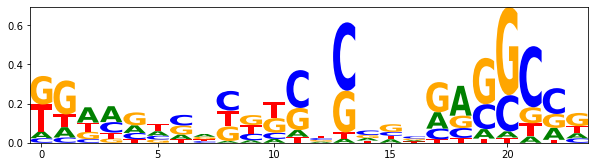

In [10]:
# Sequence Logo Plotting

lm.Logo(seq_logo_mat)